# Investigating the Causes of Exercise-Induced Angina
### Cabrinha Clark, Carol Dong, Tanishka Gandhi, Astrid Zhang


## Introduction
Heart disease is the leading cause of death for both men and women of all racial and ethnic backgrounds within the United States. About 20.5 million U.S. adults have coronary artery disease, which occurs when the vessels supplying blood to your heart narrow. Exercise-induced angina, a common preset symptom of coronary artery disease, is chest pain that occurs due to reduced blood flow to the heart when an individual exercises. 

While it is good to exercise regularly, this symptom needs to be taken into consideration when deciding the right fitness plan for the individual to avoid heart disease. For example, an individual more prone to angina due to movement should lower the intensity of their cardio to avoid an episode. Our project will be performing data analysis on the cleve.mod dataset, containing test results of patients undergoing angiography at Cleveland Clinic to investigate what other factors may cause an individual to suffer exercise-induced angina, and to report our findings on this matter.

Therefore, this research will investigate the question: 
 **How do factors such as cholesterol level, maximum heart rate, and age impact the likelihood of an individual experiencing exercise-induced angina?**



## Preliminary Exploratory Data Analysis
### Loading in libraries and the data set

In [1]:
## Loading libraries:
library(tidyverse)
library(readr)
library(tidymodels)
library(stringr)
options(repr.matrix.max.rows = 6)

# Set seed to ensure reproducibility
set.seed(1)

## Hide message
show_col_types = FALSE

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### Cleaning and wrangling data

In [2]:
## Clean and wrangle data 

# Set seed to ensure reproducibility

## Loading data set with a url
file_url <- "http://raw.githubusercontent.com/kakeysword/dsci100-heart-disease/main/cleve.mod"

heart_disease_data <- read_delim(url(file_url), ",", skip = 19, col_names = FALSE)

## Assigning column names to the data set
heart_disease_clean <- heart_disease_data |> 
    separate(X1, into = c("age", "sex", "cp", "trestbps", "chol","fbs", 
                   "restecg", "thalach", "exang", "oldpeak", "slope", 
                   "ca", "thal", "num"), sep = "\\s+")

## Changing columns to the correct type
heart_disease_clean <- mutate_at(heart_disease_clean, 
                             c("age", "trestbps", "chol", "thalach", "oldpeak", "ca", "num"),
                            as.numeric) |>
    mutate(exang = as_factor(exang)) |>
    select(exang, age, trestbps, chol, thalach, ca, oldpeak)

#selecting our choosen variables
heart_disease_final <- mutate_at(heart_disease_clean, 
                             c("age", "chol", "thalach", "oldpeak"),
                            as.numeric) |>
    mutate(exang = as_factor(exang)) |>
    select(exang, age, chol, thalach, oldpeak)

## Replace all values of "fal" in exang column to "false" for better readablity
heart_disease_clean$exang <- str_replace(heart_disease_final$exang, "fal", "false")

## Splitting the data into training and testing
heart_disease_split <- initial_split(heart_disease_final, prop = 0.75, strata = exang)

heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_train    


Rows: 303 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 14 pieces. Additional pieces discarded in 303 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = .Primitive("as.double")(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


exang,age,chol,thalach,oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
fal,63,233,150,2.3
fal,37,250,187,3.5
fal,57,192,148,0.4
⋮,⋮,⋮,⋮,⋮
true,42,315,125,1.8
true,57,207,168,0.0
true,74,269,121,0.2


### Building K Classification Model



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


[1] 7

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = best_k
  weight_func = rectangular

Computational engine: kknn 


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6447368


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.74


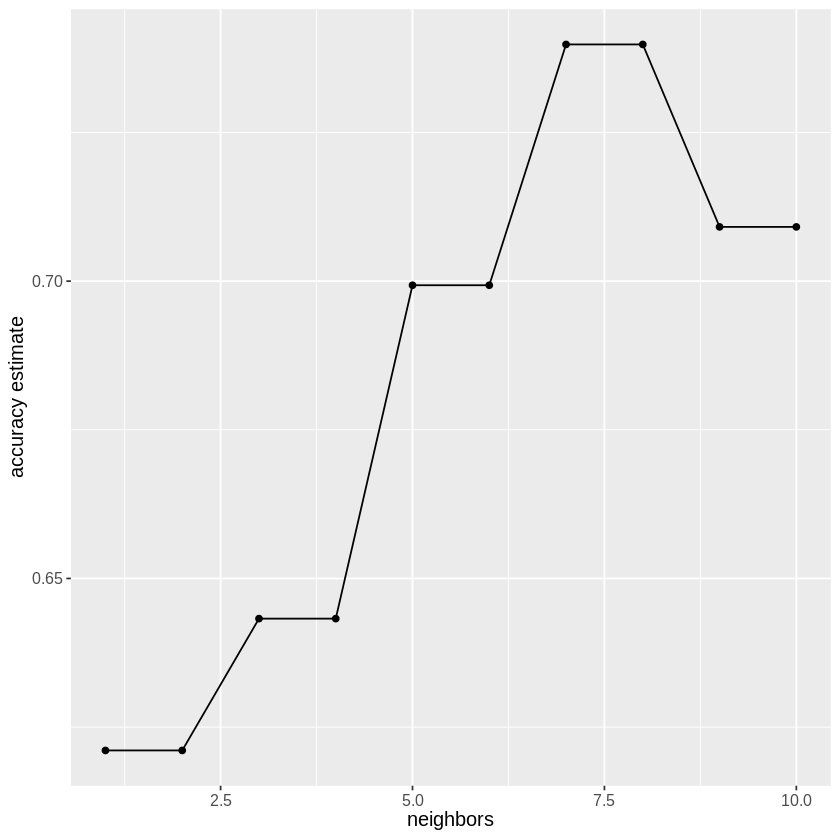

In [3]:
#setting seed
set.seed(1)

#recipe
heart_recipe <- recipe(exang ~ age + chol + thalach + oldpeak, data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
heart_recipe

#heart spec
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")
knn_spec

#add vfold
vfold <- vfold_cv(heart_disease_train, v = 10, strata = exang)

vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#workflow
heart_workflow <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = vfold, grid = vals) |>
    collect_metrics()

#testing accuracy
accuracies <- heart_workflow  |>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() +
    labs(x = "neighbors", y = "accuracy estimate") + 
    theme(text = element_text(size = 12))
accuracy_vs_k

best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k

#knn_spec with new k-value 
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
set_engine("kknn") |>
set_mode("classification")
knn_spec_2

knn_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec_2) |>
    fit(data = heart_disease_train)

#prediction
heart_test_predictions <- predict(knn_fit, heart_disease_test) |>
    bind_cols(heart_disease_test)

heart_test_predictions |>
    metrics(truth = exang, estimate = .pred_class)|>
    filter(.metric == "accuracy")

heart_test_predictions |>
    precision(truth = exang, estimate = .pred_class, event_level = "first")

### Summarizing the data

In [4]:
## Data to see number of occurences of exercise-induced angina

sum_heart_disease <- heart_disease_train |>
    group_by(exang) |>
    summarize(count = n(),
             avg_age = mean(age),         
             avg_chol = mean(chol),      
             avg_thalach = mean(thalach),
             min_age = min(age),
             min_chol = min(chol),
             min_thalach = min(thalach),
             max_age = max(age),
             max_chol = max(chol),
             max_thalach = max(thalach)) 

sum_heart_disease

exang,count,avg_age,avg_chol,avg_thalach,min_age,min_chol,min_thalach,max_age,max_chol,max_thalach
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fal,153,53.66013,242.1373,156.3203,29,126,90,76,564,202
true,74,55.72973,248.5135,136.6081,35,131,88,74,353,186


### Visualizing the data

exang,age,trestbps,chol,thalach,ca,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,63,145,233,150,0,2.3
true,67,160,286,108,3,1.5
true,67,120,229,129,2,2.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,49,118,149,126,3,0.8
true,74,120,269,121,1,0.2
false,54,160,201,163,1,0.0


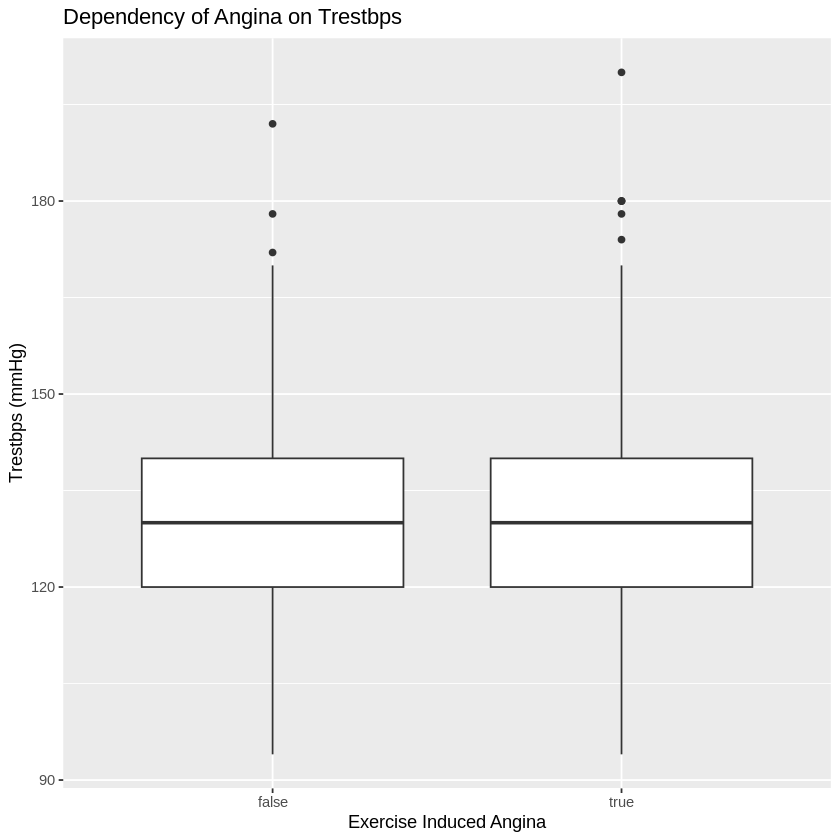

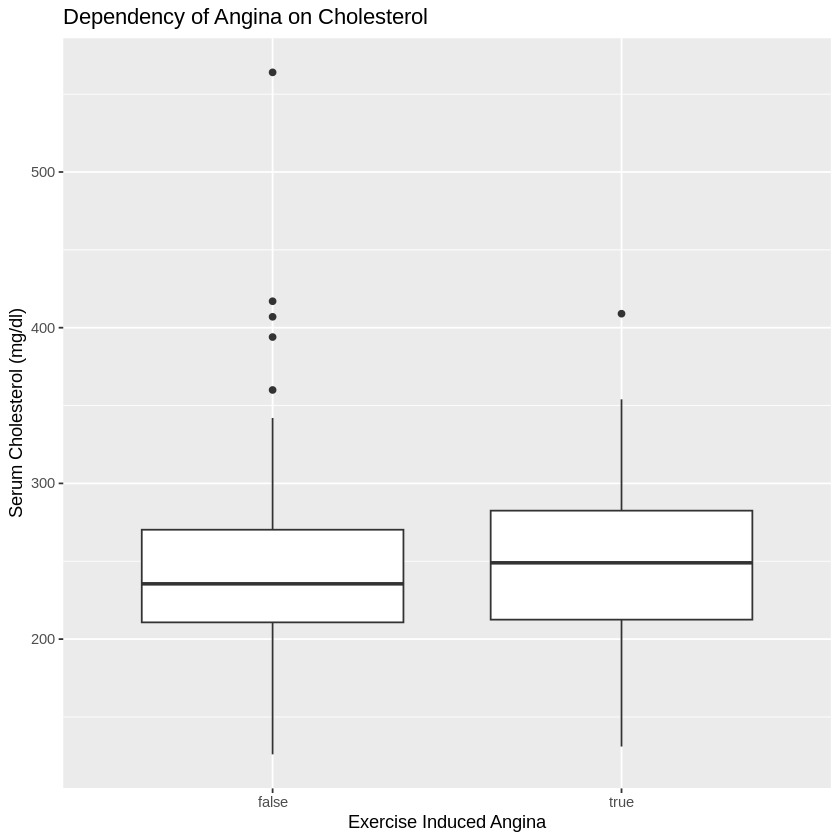

Warning message:
“Removed 5 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


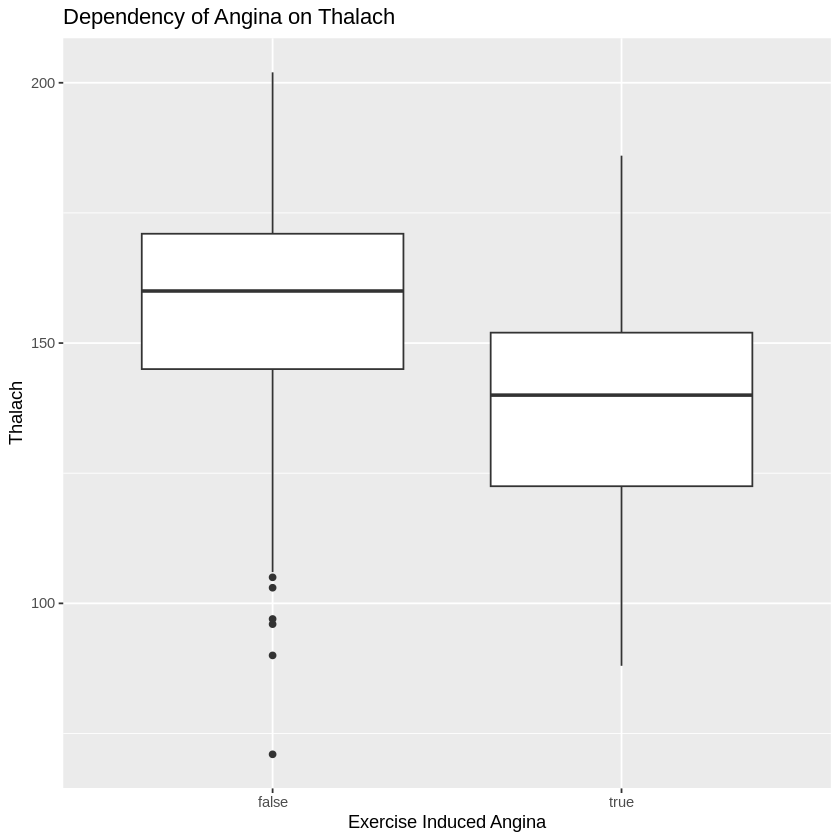

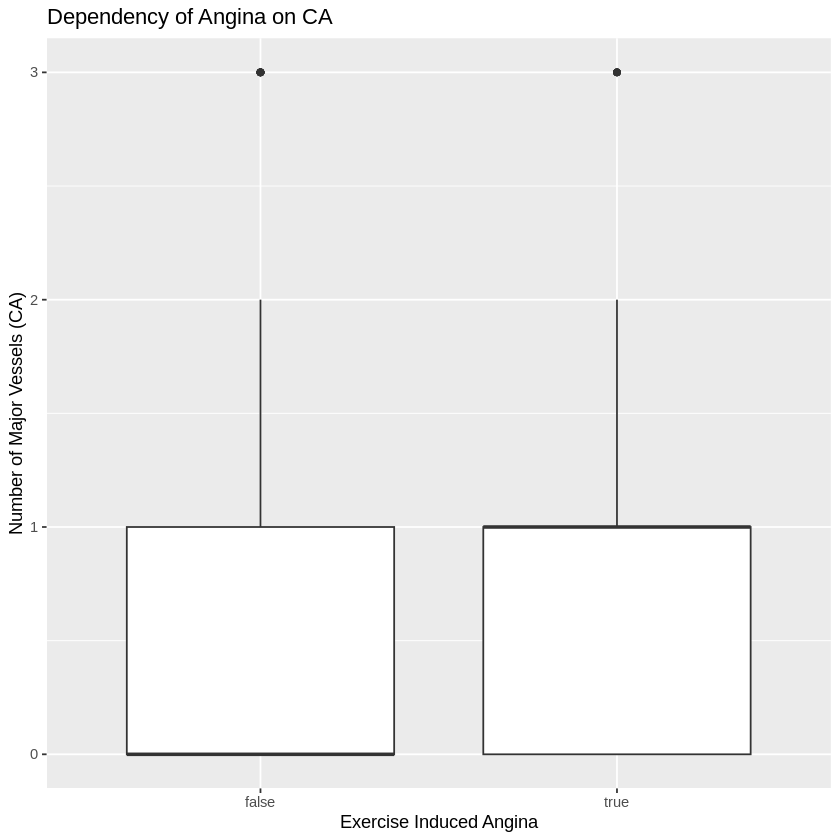

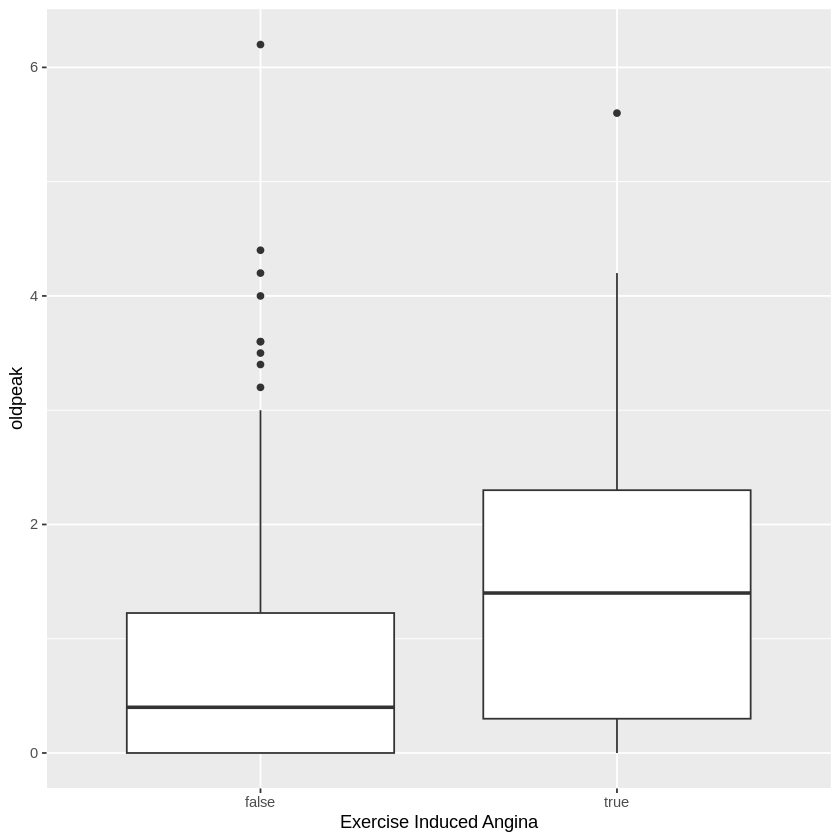

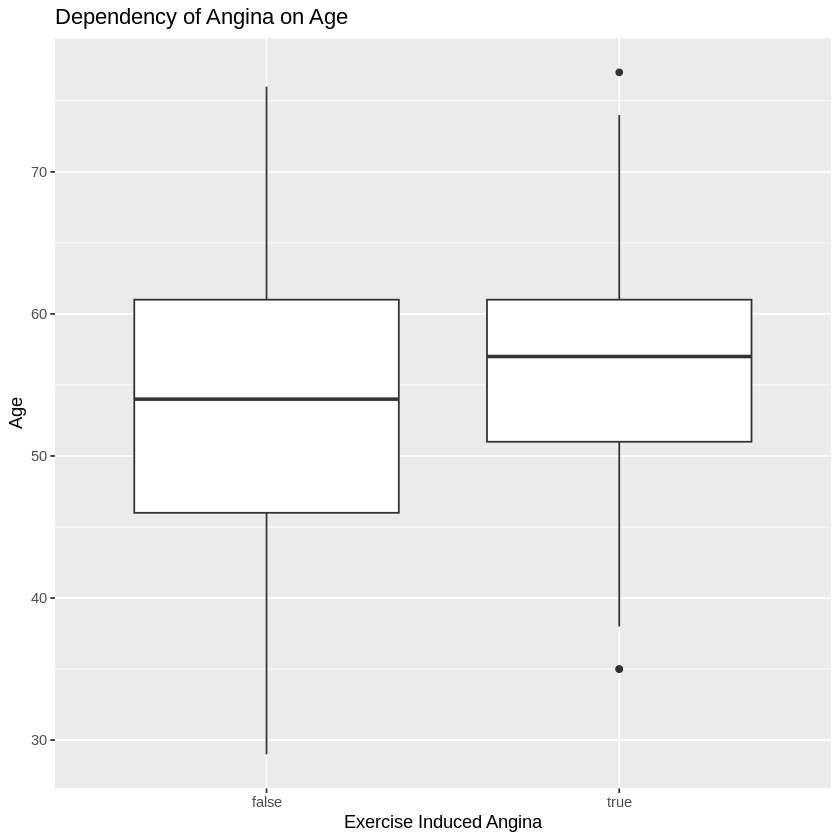

In [8]:
## Create plots to visualize data
heart_disease_clean

#boxplot for trestbps
trestbps_plot <- heart_disease_clean |>
    ggplot(aes(y = trestbps, x = exang)) +
    geom_boxplot() +
    labs(y = "Trestbps (mmHg)", x = "Exercise Induced Angina", title = "Dependency of Angina on Trestbps")
trestbps_plot

#boxplot for cholesterol
chol_plot <- heart_disease_clean |>
    ggplot(aes(y = chol, x = exang)) +
    geom_boxplot() +
    labs(y = "Serum Cholesterol (mg/dl)", x = "Exercise Induced Angina", title = "Dependency of Angina on Cholesterol")
chol_plot

#boxplot for thalach
thalach_plot <- heart_disease_clean |>
    ggplot(aes(y = thalach, x = exang)) +
    geom_boxplot() +
    labs(y = "Thalach", x = "Exercise Induced Angina", title = "Dependency of Angina on Thalach")
thalach_plot

#boxplot for ca
ca_plot <- heart_disease_clean |>
    ggplot(aes(y = ca, x = exang)) +
    geom_boxplot() +
    labs(y = "Number of Major Vessels (CA)", x = "Exercise Induced Angina", title = "Dependency of Angina on CA")
ca_plot

#boxplot for oldpeak 
oldpeak_plot <- heart_disease_clean |>
    ggplot(aes(y = oldpeak, x = exang)) +
    geom_boxplot() +
    labs(y = "oldpeak", x = "Exercise Induced Angina")
oldpeak_plot

#boxplot for age 
age_plot <- heart_disease_clean |>
    ggplot(aes(y = age, x = exang)) +
    geom_boxplot() +
    labs(y = "Age", x = "Exercise Induced Angina", title = "Dependency of Angina on Age")
age_plot


## Methods
After loading in the necessary libraries, we loaded in the `cleve.mod` data set from the Heart Disease Database, which contains data taken from patients at the Cleveland Clinic in Cleveland Ohio.
Our data analysis will be preparing to perform a classification to determine whether a new patient is likely to experience exercise-induced angina.
We are using `exang` (exercised-induced angina) as our classification variable, and the following 3 columns as the predictors: `age, chol, thalach`. <br><br>
`exang` : Exercise induced angina (true or false) <br>
`age` : Age in years <br>
`chol` : serum cholesterol (mg/dl) <br>
`thalach` : maximum heart rate <br>

When cleaning the data, we made sure to separate the data into individual columns, and convert them into the correct type (e.g. numeric for numerical variables) as everything was of type character when the data set was first loaded in. <br> <br>
Next, we split the `heart_disease_data` into 3/4 training and 1/4 testing data, setting `strata` to `exang`. <br> <br>
When summarizing the data, we grouped the training dataset by `exang`, and then found the number of patients that did or did not experience exercise-induced angina, and also found the mean, minimum and maximum value for each grouping. <br> <br>
For the visualization of our data, we created three scatter plots with the predictive variables using the training data:
 * `chol` vs `age` 
 * `thalach` vs `age`
 * `chol` vs `thalach` <br><br>
As a result, we can see a weak positive relationship between `chol` and `age` in the first plot. The age distribution implicates that more patients older in age have experienced exercise-induced angina more than patients younger in age, as more data points with the `true` value tend to the right side of the plot. <br>The second plot shows a weak negative trend, showing that the maximum heart rate decreases with age. We can also see that patients who do not have exercise-induced angina tend to have a higher maximum heart rate. <br>The third plot does not show a clear linear trend between cholesterol levels and heart rate, suggesting that patients with varying heart rates tend to have similar cholesterol levels.

## Expected Outcomes and Significance
**What we expect to find：**  
For our first variable, age, we expect to see a positive relationship between age and anginal pain. Scientific studies prove that as humans age, the level of oxygen concentration within the blood decreases. For serum cholesterol, higher blood cholesterol concentration is associated with less oxygen transport within the blood. Therefore, we expect to find higher serum cholesterol levels among patients that have experienced exercise-induced angina. Maximum heart rate indicates the demand for blood and oxygen of the heart. We expect to find a positive correlation between each predictive variable and the number of individuals experiencing exercise-induced angina.

**The impact of our findings：**  
Many doctors recommend exercise for various types of medical concerns. Our research findings could influence doctors to offer safer remedies to their patients. For example, prior to recommending high-intensity exercise to their patients, a medical professional can consider the three predictive variables within our study to analyze how susceptible the patient is to heart pain during movement. This could decrease the risk of a patient experiencing exercise-induced angina by prescribing a lower intensity plan.

**Future questions this could lead to：**
* How effective would maintaining a lower cholesterol level and heart rate be towards preventing exercise-induced angina?
* What other factors could be strong indicators that an individual is susceptible to experiencing angina?


## Bibliography

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X. 
<br><br>
Buchwald H, O'Dea TJ, Menchaca HJ, Michalek VN, Rohde TD. Effect of plasma cholesterol on red blood cell oxygen transport. Clin Exp Pharmacol Physiol. 2000 Dec;27(12):951-5. doi: 10.1046/j.1440-1681.2000.03383.x. PMID: 11117230.<br><br>
Cunha, John P., editor. "What Is a Good Oxygen Rate by Age?" emedicinehealth,  www.emedicinehealth.com/what_is_a_good_oxygen_rate_by_age/article_em.htm <br><br>
Beckett N, Nunes M, Bulpitt C. Is it advantageous to lower cholesterol in the elderly hypertensive? Cardiovasc Drugs Ther. 2000 Aug;14(4):397-405. doi: 10.1023/a:1007812232328. PMID: 10999646.<br><br>
Crooks CJ, West J, Morling J, Simmonds M, Juurlink I, Briggs S, Cruickshank S, Hammond-Pears S, Shaw D, Card T, Fogarty AW. Inverse association between blood pressure and pulse oximetry accuracy: an observational study in patients with suspected or confirmed COVID-19 infection. Emerg Med J. 2023 Mar;40(3):216-220. doi: 10.1136/emermed-2022-212443. Epub 2022 Dec 7. PMID: 36600468. <br><br>
Schantz P, Salier Eriksson J, Rosdahl H. The heart rate method for estimating oxygen uptake: analyses of reproducibility using a range of heart rates from commuter walking. Eur J Appl Physiol. 2019 Dec;119(11-12):2655-2671. doi: 10.1007/s00421-019-04236-0. Epub 2019 Oct 18. PMID: 31628539; PMCID: PMC6858472. <br><br>
Medical News Today. www.medicalnewstoday.com/articles/does-exercise-lower-cholesterol#:~:text=According%20to%20the%20AHA%2C%20150,also%20help%20raise%20HDL%20cholesterol. Accessed 9 Mar. 2024. <br><br>
"What Is Coronary Heart Disease." National Heart, Lung, and Blood Institute, www.nhlbi.nih.gov/health/coronary-heart-disease#:~:text=About%2020.5%20million%20U.S.%20adults,the%20surface%20of%20the%20heart. Accessed 9 Mar. 2024. 



In [63]:

heart_disease_clean <- heart_disease_data |> 
    separate(X1, into = c("age", "sex", "cp", "trestbps", "chol","fbs", 
                   "restecg", "thalach", "exang", "oldpeak", "slope", 
                   "ca", "thal", "num"), sep = "\\s+")


Warning message:
“Expected 14 pieces. Additional pieces discarded in 303 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
